### Thực hành MHNC BÀI 4

### Nguyễn Minh Hoàng 18110095

In [1]:
#import thư viện cần thiết
## thư viện machine learning và hỗ trợ
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from keras.initializers import glorot_uniform
from tensorflow.keras.layers import (Input, Dense ,Conv2D,  MaxPooling2D,
                                     AveragePooling2D, Flatten,
                                     BatchNormalization, ReLU)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test
Mỗi ảnh có một kênh màu, kích thước 28x28

Ảnh đầu tiên của tập train
Label đầu tiên của tập train:  5


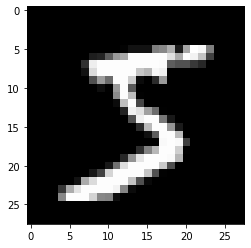

In [2]:
# Tải dataset MNIST từ tensorflow
## MNIST là bài toán dự đoán một ảnh thể hiện ký tự số nào trong các số từ 1 đến 10
## tải MNIST dataset từ keras
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
##resacle ảnh thành ảnh thực trong đoạn [0,1]
X_train, X_test = X_train/255.0, X_test/255.0

##in dataset
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print("Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test")
print("Mỗi ảnh có một kênh màu, kích thước 28x28")
print()

## in thử ảnh một ảnh
print("Ảnh đầu tiên của tập train")
print("Label đầu tiên của tập train: ", y_train[0])
plt.imshow(X_train[0], cmap='gray')
plt.show()

#Tách một phần tập train thành tập valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

## Cài thử mạng ResNet 50 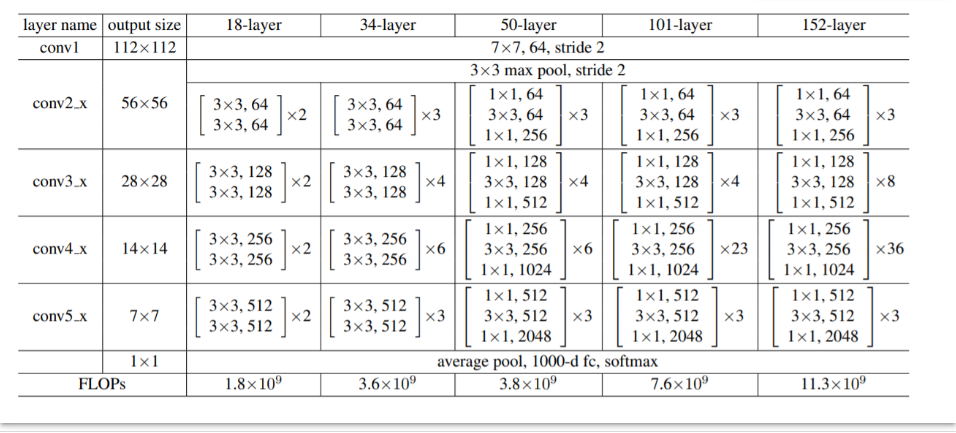

In [3]:
@tf.keras.utils.register_keras_serializable()
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters=[64,64,64], kernel_size= 3, down_sampling=False,**kwargs):
        ## Gọi hàm khởi tạo của keras.layers.Layer và lưu lại các thông số
        self.n_filters = n_filters
        self.kernel_size = kernel_size
        self.down_sampling = down_sampling
        super(ResidualBlock, self).__init__(**kwargs)
    def get_config(self):
        config = super(ResidualBlock, self).get_config()
        config.update({
            'n_filters': self.n_filters,
            "kernel_size": self.kernel_size,
            "down_sampling": self.down_sampling,
        })
        return config
    def build(self, input_shape):
        self.F1, self.F2, self.F3 = self.n_filters
        self.f = self.kernel_size
        ## Xác định xem input_shape có bằng output_shape không
        # self.projection_shortcut = (int(input_shape[-1]) != self.n_filters) or self.down_sampling
        self.projection_shortcut = self.down_sampling
        s = 1
        ## Nếu cần down sampling thì convolutional layer đầu tiên dùng strides=[2,2]
        if self.projection_shortcut :
          s = 2
        ##Khai báo các layer nhánh chính
        self.conv1 = Conv2D(filters     = self.F1,
                            kernel_size = [1,1],
                            strides     = [s,s],
                            padding     = 'valid',
                            kernel_initializer = glorot_uniform(seed=0),
                            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            activation  = None)
        self.batch1 = BatchNormalization()
        self.relu1 = ReLU()
        # --------------------------------------------------------
        self.conv2 = Conv2D(filters     = self.F2,
                            kernel_size = [self.f,self.f],
                            strides     = [1,1],
                            padding     = 'same',
                            kernel_initializer = glorot_uniform(seed=0),
                            kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            activation  = None)
        self.batch2 = BatchNormalization()
        self.relu2 = ReLU()
        # --------------------------------------------------------
        self.conv3 = Conv2D(filters     = self.F3,
                            kernel_size = [1,1],
                            strides     = [1,1],
                            padding     = 'valid',
                            kernel_initializer = glorot_uniform(seed=0),
                            kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
                            activation=None)
        self.batch3 = BatchNormalization()
        ## Khai báo các layer nhánh shortcut
        if self.projection_shortcut:
            self.shortcut_conv = Conv2D(filters     = self.F3,    ### N_FILETERS bằng N_FILTERS của output
                                        kernel_size = [1,1],      ### KERNEL_SIZE = [1,1]
                                        strides     = [s,s],      ### STRIDES: giống STRIDES của conv đầu
                                        padding     = 'valid',
                                        kernel_initializer = glorot_uniform(seed=0),
                                        kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                        activation  = None)
            self.shortcut_batch = BatchNormalization()
        self.final_relu = ReLU()
    def call(self, inputs):
        ## Thiết lập các input cho các layer đã khai báo
        x = self.relu1(self.batch1(self.conv1(inputs)))
        x = self.relu2(self.batch2(self.conv2(x)))
        x = self.batch3(self.conv3(x))
        # ----------------------------------------------------------
        if self.projection_shortcut:
            shortcut_conv = self.shortcut_conv(inputs)
            shortcut_conv = self.shortcut_batch(shortcut_conv)
            ## Nếu input_shape != output_shape thì shortcut là convolutional layer
            shortcut = shortcut_conv
        else:
            ## Nếu input_shape == output_shape thì shortcut là inputs
            shortcut = inputs
        x = x + shortcut
        x = self.final_relu(x)
        return x

In [7]:


def ResNet50(input_shape , num_classes) :
  inputs = Input(shape = input_shape)
  ### Conv 1
  x = Conv2D(filters=64,kernel_size=[7,7],strides=[2,2],activation=None, kernel_initializer = glorot_uniform(seed=0))(inputs)
  x = BatchNormalization()(x)       
  x = ReLU()(x)
  x = MaxPooling2D(pool_size=[3,3],strides=[2,2])(x)
  #----------------------------------------------------------------------------------
  ### Từ Conv 2 tới Conv 5
  list_n_filters = [[64,64,256], [128,128,512], [256,256,1024], [512,512,2048]]
  list_n_blocks = [2,3,5,2]
  j = 1
  for n_filters, n_blocks in zip(list_n_filters,list_n_blocks):
    x = ResidualBlock(n_filters = n_filters, kernel_size = 3, down_sampling= True)(x)
    for i in range(n_blocks):
      x = ResidualBlock(n_filters = n_filters, kernel_size = 3, down_sampling= False)(x)
    j += 1
  #----------------------------------------------------------------------------------
  x = AveragePooling2D((2,2), padding = "same")(x)
  x = Flatten()(x)
  outputs = Dense(num_classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(x)
  # Create model
  model = Model(inputs = inputs, outputs = outputs, name='ResNet50')
  return model

model_resnet50 = ResNet50(input_shape = (28,28,1), num_classes = 10)
model_resnet50.summary()


Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        3200      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
residual_block_16 (ResidualB (None, 3, 3, 256)         76928     
_________________________________________________________________
residual_block_17 (ResidualB (None, 3, 3, 256)         715

In [8]:
model_resnet50.compile(loss = tf.keras.losses.sparse_categorical_crossentropy, 
              optimizer = tf.keras.optimizers.RMSprop(learning_rate= 1e-4, name='RMSprop'),
              metrics=['accuracy']
              )

mc = tf.keras.callbacks.ModelCheckpoint(filepath="epoch: {epoch:02d}.hdf5", 
                                     monitor='val_accuracy',
                                     mode='max', 
                                     verbose=1,
                                     save_best_only=True)
history = model_resnet50.fit(X_train, y_train,
                    batch_size= 100,
                    epochs= 10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[mc])      


Epoch 1/10
540/540 [==============================] - 86s 129ms/step - loss: 6.6468 - accuracy: 0.6740 - val_loss: 5.7660 - val_accuracy: 0.7878

Epoch 00001: val_accuracy improved from -inf to 0.78783, saving model to epoch: 01.hdf5
Epoch 2/10
540/540 [==============================] - 67s 124ms/step - loss: 4.4243 - accuracy: 0.9460 - val_loss: 3.6865 - val_accuracy: 0.9618

Epoch 00002: val_accuracy improved from 0.78783 to 0.96183, saving model to epoch: 02.hdf5
Epoch 3/10
540/540 [==============================] - 68s 126ms/step - loss: 3.1069 - accuracy: 0.9698 - val_loss: 2.6962 - val_accuracy: 0.9633

Epoch 00003: val_accuracy improved from 0.96183 to 0.96333, saving model to epoch: 03.hdf5
Epoch 4/10
540/540 [==============================] - 68s 126ms/step - loss: 2.3280 - accuracy: 0.9778 - val_loss: 2.1283 - val_accuracy: 0.9672

Epoch 00004: val_accuracy improved from 0.96333 to 0.96717, saving model to epoch: 04.hdf5
Epoch 5/10
540/540 [==============================] - 6

In [10]:
#ta chọn epoch thứ 10 làm best model
model = tf.keras.models.load_model("/content/epoch: 10.hdf5")
result = model.evaluate(X_test,y_test)
print("loss và accuracy trên tập test là {} {}".format(result[0],result[1]))

313/313 [==============================] - 11s 30ms/step - loss: 1.0797 - accuracy: 0.9838
loss và accuracy trên tập test là 1.079702615737915 0.9837999939918518
